# Introduction

*Section 1* of this notebook can be used to investigate where in CBC parameter space it is possible to observe precession. The user specifies desired parameter values and the code carries out a matched-filtering algorithm to calculate the *Match* ($\mathcal{M}$) between a precessing waveform and a non-precessing waveform of the same source (identical $[m_1,m_2,\chi_{eff}]$), carried out over a range of different initial conditions.

This assumes the best-fitting non-precessing waveform has identical intrinsic parameters (masses and spins) to the precessing waveform minus precessional spin. If f you want to test this, carry out a few mildly precessing injection runs with an aligned-spin template bank and see if the best matches aren't of near-identical masses and aligned spins to the injections. I haven't done that.

This means $[m_1,m_2,\chi_{eff}]$ are constant for any given run of injections with corresponding template. (The orientation angles only affect amplitude for non-precessing waveforms, which is maximised in the matched-filtering process, thus the template need not have the same values of $[\theta_{JN},\psi,\phi_{JL},\phi_{ref}]$.)

$\mathcal{M}$ values between precessing and non-precessing waveforms are calculated over two-dimensional parameter spaces and plotted. Two different parameter spaces are investigated:

Plot 1: $\mathcal{M}$ vs $\theta_{JN}$ vs $\chi_p$ , for fixed [$m_1,m_2,\chi_{eff},\psi,\phi_{JL},\phi_{ref}$].

Plot 2: $\mathcal{M}$ vs $\theta_{JN}$ vs $\psi$ , for fixed [$m_1,m_2,\chi_{eff},\chi_p,\phi_{JL},\phi_{ref}$].

*Section 2* describes some investigating I've done using these codes, keeping to the approximant $\texttt{IMRPhenomPv2}$ and focussing solely on waveforms where the smaller mass does not contribute to $[\chi_p,\chi_{eff}]$.

See code windows titled "USER INPUT WINDOW: ..." to set parameter values.

## Import libraries, functions, constants, numpies

In [3]:
'''The usual numpy stuff'''
%matplotlib inline
import pylab as py
from numpy import *

'''Waveform approximants'''
from pycbc.waveform import get_fd_waveform, get_td_waveform, td_approximants

'''Coordinate transform functions'''
from lalsimulation import SimInspiralTransformPrecessingNewInitialConditions
from lalsimulation import SimInspiralInitialConditionsPrecessingApproxs

'''Matched Filtering functions'''
from pycbc.filter import match, sigmasq

'''PSD'''
from pycbc.psd import aLIGOZeroDetHighPower

'''Some other objects from PyCBC'''
from pycbc.types import FrequencySeries, TimeSeries
import pycbc.psd
from pycbc.types import real_same_precision_as
from pycbc.types import complex_same_precision_as

'''Physical constants'''
from lal import MSUN_SI, G_SI, C_SI

from mpl_toolkits.mplot3d import Axes3D

/Users/awmuir/src/pycbc/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Define detector strain

In [4]:
def my_generate_fplus_fcross(latitude,longitude,polarization):
    f_plus = (- (1.0/2.0) * (1.0 + cos(latitude) * cos(latitude)) 
              * cos (2.0 * longitude) * cos (2.0 * polarization) 
              - cos(latitude) * sin(2.0 * longitude) * sin (2.0 * polarization) )
    
    f_cross= ( (1.0/2.0) * (1.0 + cos(latitude) * cos(latitude)) 
              * cos (2.0 * longitude) * sin (2.0 * polarization) 
              - cos (latitude) * sin(2.0 * longitude) * cos (2.0 * polarization) )
    
    return f_plus, f_cross

def my_generate_detector_strain(h_plus, h_cross, polarization,latitude,longitude):
    f_plus, f_cross = my_generate_fplus_fcross(latitude, longitude, polarization)
    return f_plus * h_plus + f_cross * h_cross

# *SECTION 1* - The Algorithms

## Plot 1: $\mathcal{M}$ vs $\theta_{JN}$ vs $\chi_p$

### ***USER INPUT WINDOW***: Define parameter values

In [101]:
'''CODE I'''
'''------'''

'''Give the source masses (in solar masses)'''
mass1 = 20.
mass2 =  5. 

if mass2>mass1:     #These parameters are degenerate enough without your help. mass1 is always bigger.
    tmpmass = mass2
    mass2 = mass1
    mass1 = tmpmass

'''Give the values of dimensionless aligned spin (-1 to 1)'''
spin_z1 =  0.
spin_z2 =  0.

'''Give ranges of chi_p and thetaJN (degrees)'''
chirange = 31  #Number of waveforms with different chi_p values to be matched.
chip_min = 0
chip_max = 0.99  #NOTE: Be careful to ensure for all waveforms: chi_p**2 + spin_z**2 < 1

JNrange     = 31  #Number of waveforms with different thetaJN to be matched.
thetaJN_min = 0   #DEGREES, PLEASE
thetaJN_max = 180 #DEGREES, PLEASE
#------------------------------------------------------------------------------------------------------
#For investigations with spin contributions from both masses:
'''
chirange = 31
chiperp1_min = 0
chiperp1_max = 0.99 
chiperp2_min = 0
chiperp2_max = 0.99
'''
#------------------------------------------------------------------------------------------------------

'''Give orientation angles (degrees)'''
phi12      =   0.  #phi12 = azimuthal angle between spins.
phi_JL     = 270.  #phi_JL = phase of precession of L around J.
psi        =  45.  #Polarisation
phiRef     =   0.  #Reference phase, for PhiRef in SimInspiralTransformPrecessingNewInitialConditions()

'''Give sky location (zero = above detector)'''
latitude  = 0
longitude = 0

'''Give distance to source in Mpc'''
dist = 410.

'''Give sample rate and frequency limits'''
low_f   = 30.  #Starting frequency
delta_t = 1./2048
#For fd waveforms: delta_f = 2048

### Parameters are calculated and arrays initialised, ready for loop:

In [102]:
'''CODE II'''
'''-------'''

''' [No user input required] '''

'''Convert angles to radians'''
thetaJN_min = radians(thetaJN_min)
thetaJN_max = radians(thetaJN_max)
phi12       = radians(phi12)
phi_JL      = radians(phi_JL)
psi         = radians(psi)
phiRef       = radians(phiRef)


'''Create arrays for thetaJN and chi_p'''
theta_JN = linspace(thetaJN_min, thetaJN_max, JNrange)
chi_p    = linspace(chip_min, chip_max, chirange)

'''chi1,chi2,theta1,theta2'''
if spin_z1==0.: spin_z1=10e-10           #To avoid divisions by zero.
if spin_z1<0: theta1z = pi               #Gives non-precessing waveform appropriate spin polar angles.
else: theta1z = 0
if spin_z2<0: theta2z = pi
else: theta2z = 0
chi1    = sqrt(spin_z1**2 + chi_p**2)   #Calculate spin magnitude.
theta1  = arccos((spin_z1)/chi1)        #Calculate polar angle.
chi2    = zeros(chirange)
theta2  = zeros(chirange)
#------------------------------------------------------------------------------------------------------
#For investigations with spin contributions from both masses:
'''
chi_perp1   = linspace(chiperp1_min, chiperp1_max, chirange)
chi_perp2   = linspace(chiperp2_min, chiperp2_max, chirange)
theta_z1 = arccos(spin_z1/abs(spin_z1))
theta_z2 = arccos(spin_z2/abs(spin_z2))
chi1    = sqrt(spin_z1**2 + chi_perp1**2)
theta1  = arccos(spin_z1/chi1)
chi2    = sqrt(spin_z2**2 + chi_perp2**2)
theta1  = arccos(spin_z2/chi2)       
'''
#------------------------------------------------------------------------------------------------------

'''Calculate chi_eff'''
chi_eff = (spin_z1*mass1 + spin_z2*mass2)/(mass1+mass2)

'''Set arrays for saving parameter values'''
s1x = zeros((chirange,JNrange))
s1y = zeros((chirange,JNrange))
s1z = zeros((chirange,JNrange))
s2x = zeros((chirange,JNrange))
s2y = zeros((chirange,JNrange))
s2z = zeros((chirange,JNrange))
inc = zeros((chirange,JNrange))
match1 = zeros((chirange,JNrange))

'''Set plotting arrays'''
chirangej = complex(0,chirange)
JNrangej = complex(0,JNrange)
chip_plot,thetajn_plot = mgrid[0:chip_max:chirangej,0:thetaJN_max:JNrangej]

#------------------------------------------------------------------------------------------------------
#For investigations with spin contributions from both masses:
#CHI_P_MAX = {INSERT CALCULATION FOR MAXIMUM CHI_P}
#chip_plot,thetajn_plot = mgrid[0:CHI_P_MAX:chirangej,0:thetJN_max:JNrangej]
#------------------------------------------------------------------------------------------------------

### Non-precessing waveform is generated and data length to calculated a frequency sample rate for PSD:

In [103]:
'''CODE III'''
'''--------'''

'''Function to extract initial inclination, S1 and S2 from parameter values'''
np_inc, np_s1x, np_s1y, np_s1z, np_s2x, np_s2y, np_s2z = SimInspiralTransformPrecessingNewInitialConditions(
                                                               0,            #theta_JN
                                                               phi_JL,       #phi_JL
                                                               theta1z,    #theta1z
                                                               theta2z,    #theta2z
                                                               0,        #phi12
                                                               abs(spin_z1),
                                                               abs(spin_z2),
                                                               mass1*MSUN_SI,
                                                               mass2*MSUN_SI,
                                                               low_f,
                                                               0 #phiRef)

'''Generate non-precessing waveform'''
temp_hplus, temp_hcross = get_td_waveform(approximant="IMRPhenomPv2",
                        inclination = np_inc,
                        mass1=mass1,
                        mass2=mass2,
                        spin1x = np_s1x,
                        spin1y = np_s1y,
                        spin1z = np_s1z,
                        spin2x = np_s2x,
                        spin2y = np_s2y,
                        spin2z = np_s2z,
                        distance = dist,
                        f_lower=low_f,
                        delta_t=delta_t)

temp_vec = my_generate_detector_strain(temp_hplus,temp_hcross,psi,latitude,longitude)
delta_f = 1./ len(temp_vec) / delta_t

### Run loop to calculate $\mathcal{M}$ for all pairs of $\theta_{JN}$ and $\chi_p$ values:

In [104]:
'''CODE IV'''
'''-------'''

for i in range(chirange):
    for j in range(JNrange):
        inc[i][j],s1x[i][j],s1y[i][j],s1z[i][j],s2x[i][j],s2y[i][j],s2z[i][j] = SimInspiralTransformPrecessingNewInitialConditions(
                                                               theta_JN[j],
                                                               phi_JL,
                                                               theta1[i],
                                                               theta2[i],
                                                               phi12,
                                                               chi1[i],
                                                               chi2[i],
                                                               mass1*MSUN_SI,
                                                               mass2*MSUN_SI,
                                                               low_f,
                                                               phiRef)
        splus, scross = get_td_waveform(approximant="IMRPhenomPv2",
                        inclination = inc[i][j],
                        mass1=mass1,
                        mass2=mass2,
                        spin1x = s1x[i][j],
                        spin1y = s1y[i][j],
                        spin1z = s1z[i][j],
                        spin2x = s2x[i][j],
                        spin2y = s2y[i][j],
                        spin2z = s2z[i][j],
                        distance = dist,
                        f_lower=low_f,
                        delta_t=delta_t)
        
        sig_vec = my_generate_detector_strain(splus,scross, psi, latitude,longitude)
        sig_vec.resize(len(temp_vec))
        PSD = aLIGOZeroDetHighPower(len(temp_vec),delta_f,low_f)

        match1[i][j], residuals = match(temp_vec,sig_vec,psd=PSD,low_frequency_cutoff=low_f)

## Plotting

### ***USER INPUT WINDOW***: Plot filename, contour lines and figure size.

In [105]:
'''Give plot filename'''
nom1 = str(int(round(degrees(phi_JL))))
nom2 = str(int(round(degrees(psi))))
nom3 = str(spin_z1)
nom4 = str(int(degrees(phiRef)))
nom5 = str(chi_eff)
name = "MatchPlot_Phi" + nom1 + "_Psi" + nom2 #+ "_chieff" + nom5[-1]     # + "_phase" + nom4
#title0 = "$\mathcal{M}$ vs $\\theta_{JN}$ vs $\chi_p$ :  $\psi=0,\phi_{JL}=0,\chi_{eff}=0.5$"

'''Choose Match contour lines to show (ascending order)'''
lines = [0.6,0.7,0.8,0.9,0.97] #Leave empty brackets [] for no lines.

'''Choose figure size'''
figsize=[15,11]

### Plot away...

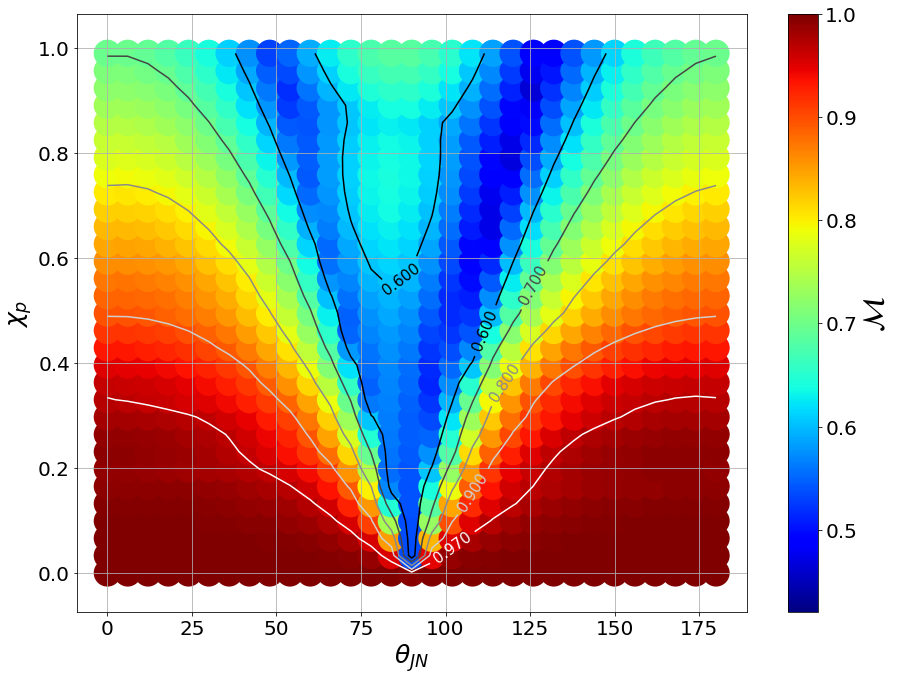

Masses:  20.0 ,  5.0
$\chi_{eff}$:  8e-10
phiJL (deg) = 270.0
psi (deg)   = 45.0
Lowest Match= 0.464567686855508


In [106]:
'''Plot Match vs thetaJN vs chi_p'''
py.figure(figsize=figsize)
py.xlabel("$\\theta_{JN}$",fontsize=25)
py.ylabel("$\chi_p$",fontsize=25)
py.scatter(degrees(thetajn_plot), chip_plot, c=match1, vmin=.42, vmax=1., s=750, cmap = 'jet', edgecolor='none')
cbar = py.colorbar()
cbar.set_label(label="$\mathcal{M}$",size=25)
Cont = py.plt.contour(degrees(theta_JN), chi_p, match1, lines, linewidth=30, cmap = 'gray')
py.grid(which='both')
py.plt.clabel(Cont, inline=1, fontsize=15)
cbar.set_label(label="$\mathcal{M}$",size=30)
cbar.ax.tick_params(labelsize=20)
py.tick_params(axis='both', which='both', labelsize=20)
#py.title(title0,fontsize=20)
py.savefig(name)
py.show()

'''Print parameter values'''
print "Masses: ",mass1, ", ", mass2
print "$\chi_{eff}$: ", chi_eff
print "phiJL (deg) =", degrees(phi_JL)
print "psi (deg)   =", degrees(psi)
print "Lowest Match=", match1.min()

## Plot 2: $\mathcal{M}$ vs $\theta_{JN}$ vs $\psi$: "The Circle of Badness"

Bear in mind a lot of these variables share the same name with the variables from Plot 1. If you want the kernel to keep all your Plot 1 data, you'll have to change these names. Soz lol.

### ***USER INPUT WINDOW***: Define Parameter values

In [3]:
'''CODE I'''
'''------'''

'''Give the source masses (in solar masses)'''
mass1 = 20.
mass2 =  5.

if mass2>mass1:     #Obey the law.
    tmpmass = mass2
    mass2 = mass1
    mass1 = tmpmass

'''SPIN MAGNITUDES'''
'''Aligned spin'''
spin_z1 =  0.    #from -1 to 1
spin_z2 =  0.
'''Precessional spin magnitude'''
chi_perp1   = 0.6      #from 0 to 1.
chi_perp2   = 0.0     #This one is only interesting if the masses are near identical and you're really bored.

'''Give ranges of psi and thetaJN (degrees)'''
psirange = 21      #Number of different psi values to be matched.
psi_min  =  0     #degrees
psi_max  = 90    #degrees

JNrange     =  41    #Number of different thetaJN values to be matched.
thetaJN_min =   0   #degrees
thetaJN_max = 180  #degrees

#------------------------------------------------------------------------------------------------------
#For investigations with spin contributions from both masses:
#chirange = 25
#chiperp1_min = 0
#chiperp1_max = 0.99 
#chiperp2_min = 0
#chiperp2_max = 0.99
#------------------------------------------------------------------------------------------------------

'''Give orientation angles (degrees)'''
phi12     =  0.     #phi12 = azimuthal angle between spins.
phi_JL    =  0.    #phi_JL = phase of precession of L around J.
phase     =  0.   #Reference phase = PhiRef in SimInspiralTransformPrecessingNewInitialConditions()

'''Give sky location (zero = above detector)'''
latitude  = 0
longitude = 0

'''Give distance to source in Mpc'''
dist = 410.

'''Give sample rate and frequency limits'''
low_f   = 30.      #Starting frequency
#high_f  = 2048.    #Cut-off frequency
delta_t = 1./2048    #Sample rate
#------------------------------------------------------------------------------------------------------
#For fd waveforms
#delta_f = 2048

### Initialise arrays, calulcate variables...

In [4]:
'''CODE II'''
'''-------'''

''' [No user input required] '''

'''Convert angles to radians'''
psi_min     = radians( psi_min )
psi_max     = radians( psi_max )
thetaJN_min = radians( thetaJN_min )
thetaJN_max = radians( thetaJN_max )
phi12     = radians( phi12 )
phi_JL    = radians( phi_JL )
phase = radians( phase )

'''Create array of polarisations and thetaJNs'''
psi      = linspace(psi_min, psi_max, psirange)
theta_JN = linspace(thetaJN_min, thetaJN_max, JNrange)

'''Define spin magnitudes and inclinations'''
chi1     = sqrt(spin_z1**2 + chi_perp1**2)   #Calculate spin magnitude for each mass.
chi2     = sqrt(spin_z2**2 + chi_perp2**2)
if chi1>1:
    chi1=1.0                        #Prevent Kerr limit being exceeded
    print "WARNING: KERR LIMIT EXCEEDED. BLACK HOLE GIVEN EXTREME KERR SPIN INSTEAD. BE BETTER AT MATHS."
if chi2>1:
    chi2=1.0
    print "WARNING: KERR LIMIT EXCEEDED. BLACK HOLE GIVEN EXTREME KERR SPIN INSTEAD. BE BETTER AT MATHS."
if chi1 == 0.: chi1 = 10e-10               #Prevent division by zero.
if chi2 == 0.: chi2 = 10e-10
if spin_z1<0: theta1z = pi               #Gives non-precessing waveform appropriate spin polar angles.
else: theta1z = 0
if spin_z2<0: theta2z = pi
else: theta2z = 0
theta1  = arccos(spin_z1/chi1)           #Calculate spin polar angles for for precessing waveforms.
theta2  = arccos(spin_z2/chi2)

'''Calculate chi_eff and chi_p'''
chi_eff = (spin_z1*mass1 + spin_z2*mass2)/(mass1+mass2)

#See Schmidt, Ohme & Hannam (2014): "Towards models of gravitational waves..."
q = mass1/mass2
A1 = 2. + 3.*q/2
A2 = 2. + 3./(2*q)
S1 = chi_perp1*mass1**2
S2 = chi_perp2*mass2**2
top = max(A2*S1,A1*S2)
chi_p = top/(A2*mass1**2)

'''Initialise spin, inclination and FF arrays'''
s1x = zeros((psirange,JNrange))
s1y = zeros((psirange,JNrange))
s1z = zeros((psirange,JNrange))
s2x = zeros((psirange,JNrange))
s2y = zeros((psirange,JNrange))
s2z = zeros((psirange,JNrange))
inc = zeros((psirange,JNrange))

match2 = zeros((psirange,JNrange))

'''Set plotting arrays'''
psirangej = complex(0,psirange)
JNrangej  = complex(0,JNrange)
psi_plot,thetajn_plot = mgrid[0:psi_max:psirangej,0:thetaJN_max:JNrangej]

### Create non-precessing template

In [5]:
'''CODE III'''
'''--------'''

delta_t = 1./2048

np_inc, np_s1x, np_s1y, np_s1z, np_s2x, np_s2y, np_s2z = SimInspiralTransformPrecessingNewInitialConditions(
                                                               0., #theta_JN
                                                               phi_JL, #phi_JL
                                                               theta1z, #theta1
                                                               theta2z, #theta2
                                                               phi12, #phi12
                                                               abs(spin_z1), #chi1
                                                               abs(spin_z2), #chi2
                                                               mass1*MSUN_SI,
                                                               mass2*MSUN_SI,
                                                               low_f,
                                                               phase)
temp_hplus, temp_hcross = get_td_waveform(approximant="IMRPhenomPv2",
                        inclination = np_inc,
                        mass1=mass1,
                        mass2=mass2,
                        spin1x = np_s1x,
                        spin1y = np_s1y,
                        spin1z = np_s1z,
                        spin2x = np_s2x,
                        spin2y = np_s2y,
                        spin2z = np_s2z,
                        distance = dist,
                        f_lower=low_f,
                        delta_t=delta_t)

'''Set psi=0 for this one - it doesnt make a difference anyway'''
temp_vec = my_generate_detector_strain(temp_hplus,temp_hcross, 0, latitude, longitude)
delta_f = 1./ len(temp_vec) / delta_t

### Loop to generate $\mathcal{M}$ for all pairs of $\theta_{JN}$ and $\psi$ 

In [17]:
'''CODE IV'''
'''-------'''

'''Create precessing waveforms and calculate match with non-precessing template.'''
for i in range(psirange):
    
        #Recalculate strain from non-precessing template for each polarisation - not necessary since without
            #precession, polarisation is just a scaling factor.
    #temp_vec = my_generate_detector_strain(temp_hplus,temp_hcross, psi[i], latitude, longitude)
    #delta_f = 1./ len(temp_vec) / delta_t
    
    for j in range(JNrange):
        inc[i][j],s1x[i][j],s1y[i][j],s1z[i][j],s2x[i][j],s2y[i][j],s2z[i][j], = SimInspiralTransformPrecessingNewInitialConditions(
                                                               theta_JN[j],
                                                               phi_JL,
                                                               theta1,
                                                               theta2,
                                                               phi12,
                                                               chi1,
                                                               chi2,
                                                               mass1*MSUN_SI,
                                                               mass2*MSUN_SI,
                                                               low_f,
                                                               phase)
        splus, scross = get_td_waveform(approximant="IMRPhenomPv2",
                        inclination = inc[i][j],
                        mass1=mass1,
                        mass2=mass2,
                        spin1x = s1x[i][j],
                        spin1y = s1y[i][j],
                        spin1z = s1z[i][j],
                        spin2x = s2x[i][j],
                        spin2y = s2y[i][j],
                        spin2z = s2z[i][j],
                        distance = dist,
                        f_lower=low_f,
                        delta_t=delta_t)
        
        sig_vec = my_generate_detector_strain(splus,scross, psi[i],latitude,longitude)
        sig_vec.resize(len(temp_vec))
        PSD = aLIGOZeroDetHighPower(len(temp_vec),delta_f,low_f)
        
        match2[i][j], residuals = match(temp_vec,sig_vec,psd=PSD,low_frequency_cutoff=low_f)

### ***USER INPUT WINDOW***: Plot filename, contour lines, figure size

In [18]:
'''Give plot save filename (saves with the chosen fixed parameters in the title without user interference)'''
nom0 = str(int(mass1)) + "and" + str(int(mass2))
nom1 = str(chi_p)
nom2 = str(int(round(degrees(phi_JL))))
nom4 = str(int(round(degrees(phase))))
nom5 = str(int(round(low_f)))
nom6 = str(chi_eff)
name = "CircleOfBadness_Masses" + nom0 + "_Chip" + nom1[-1] + "_phiJL" + nom2 + "_chieff" + nom6[-1]
    #When using negative chi_eff values, be sure to add this to your filename 
    # + "_lowf" + nom5 # if you're messing with these parameters you may want to add them to filename.

'''Give plot title'''
title = "$\mathcal{M}$ vs $\\theta_{JN}$ vs $\psi$ :  $\phi_{JL}=$" + nom2 + ", $\phi_{ref}=$" + nom4 + " and low_f=" + nom5
    
'''Choose Match contour lines to show (ascending order)'''
lines = [0.5,0.6,0.7,0.8,0.9,0.97] #Leave empty brackets [] for no lines.

'''Choose figure size (scalar) and dot size'''
figsize=[18,7]
dotsize=600

In [19]:
print name
print title

CircleOfBadness_Masses20and5_Chip8_phiJL90_chieff0
$\mathcal{M}$ vs $\theta_{JN}$ vs $\psi$ :  $\phi_{JL}=$90, $\phi_{ref}=$0 and low_f=20


### Get plotting

Masses:  20.0 ,  5.0
chi_p:  0.8
chi_eff:  0.0
phiJL:  90.0
phase:  0.0
low_f:  20.0
Minimum match:  0.4143591364490981


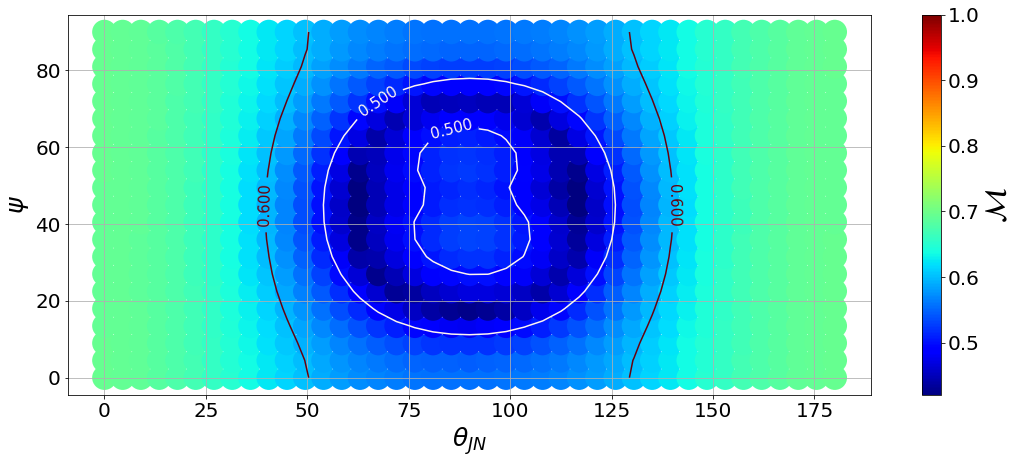

In [20]:
'''Print parameters'''
print "Masses: ", mass1, ", ", mass2
print "chi_p: ", chi_p
print "chi_eff: ", chi_eff
print "phiJL: ", degrees(phi_JL)
print "phase: ", degrees(phase)
print "low_f: ", low_f
print "Minimum match: ", match2.min()

'''Plot Match vs thetaJN vs chi_p'''
py.figure(figsize=figsize)
#py.title(title,fontsize=20)
py.xlabel("$\\theta_{JN}$",fontsize=25)
py.ylabel("$\psi$",fontsize=25)
py.scatter(degrees(thetajn_plot), degrees(psi_plot), c=match2, vmin=.42, vmax=1., s=dotsize, cmap = 'jet', edgecolor='none')
    #Alternatively, max and min colour defined by the matches:
#py.scatter(degrees(thetajn_plot), degrees(psi_plot), c=match2, vmin=match2.min(), vmax=match2.max(), s=dotsize, cmap = 'jet', edgecolor='none')
cbar = py.colorbar()
cbar.set_label(label="$\mathcal{M}$",size=25)
Cont = py.plt.contour(degrees(thetajn_plot), degrees(psi_plot), match2, lines, linewidth=30, cmap = 'Reds')
py.grid(which='both')
py.plt.clabel(Cont, inline=1, fontsize=15)
cbar.set_label(label="$\mathcal{M}$",size=30)
cbar.ax.tick_params(labelsize=20)
py.tick_params(axis='both', which='both', labelsize=20)

py.savefig(name)
py.show()

# *Section 2* - Investigation

I tried running the codes for Plot 2 with different fixed values of $\phi_{JL}$, saving the results each time, and plotting them all on one 3D graph.

Run Code I,II and III in Plot 2 (not the loop).

Set the $\phi_{JL}$ range and limits:

In [6]:
'''USER INPUT WINDOW'''
'''Set phiJL limits'''
JLrange =   9
JLmin   =   0.
JLmax   = 360.

Run this instead of the loop in Plot 2:

In [7]:
'''Initialise plotting arrays'''
JLmin = radians(JLmin)
JLmax = radians(JLmax)
phi_JL = linspace(JLmin,JLmax,JLrange)
JLrangej  = complex(0,JLrange)

match2_3D = zeros((psirange,JNrange,JLrange))

'''Off we go'''
for k in range(JLrange):
    for i in range(psirange):    
        for j in range(JNrange):
            inc[i][j],s1x[i][j],s1y[i][j],s1z[i][j],s2x[i][j],s2y[i][j],s2z[i][j], = SimInspiralTransformPrecessingNewInitialConditions(
                                                               theta_JN[j],
                                                               phi_JL[k],
                                                               theta1,
                                                               theta2,
                                                               phi12,
                                                               chi1,
                                                               chi2,
                                                               mass1*MSUN_SI,
                                                               mass2*MSUN_SI,
                                                               low_f,
                                                               phase)
            splus, scross = get_td_waveform(approximant="IMRPhenomPv2",
                        inclination = inc[i][j],
                        mass1=mass1,
                        mass2=mass2,
                        spin1x = s1x[i][j],
                        spin1y = s1y[i][j],
                        spin1z = s1z[i][j],
                        spin2x = s2x[i][j],
                        spin2y = s2y[i][j],
                        spin2z = s2z[i][j],
                        distance = dist,
                        f_lower=low_f,
                        delta_t=delta_t)
        
            sig_vec = my_generate_detector_strain(splus,scross, psi[i], latitude,longitude)
            sig_vec.resize(len(temp_vec))
            PSD = aLIGOZeroDetHighPower(len(temp_vec),delta_f,low_f)
            match2_3D[i][j][k], residuals = match(temp_vec,sig_vec,psd=PSD,low_frequency_cutoff=low_f)

### Convert back to degrees:

In [8]:
'''Converting parameters back to degrees for plotting'''
psi_min = degrees(psi_min)
psi_max = degrees(psi_max)
thetaJN_min = degrees(thetaJN_min)
thetaJN_max = degrees(thetaJN_max)
JLmin = degrees(JLmin)
JLmax = degrees(JLmax)
'''Setting 3D plotting arrays and plot it'''
psi_plot3D,thetaJN_plot3D,phiJL_plot3D = mgrid[psi_min:psi_max:psirangej, thetaJN_min:thetaJN_max:JNrangej, JLmin:JLmax:JLrangej]


## *USER INPUT WINDOW*: Plotting:

In [9]:
'''Set title and filename'''
name = "Match3D_LargeMass.png"
title1 = "$\mathcal{M}$ vs $\phi_{JL}$ vs $\\theta_{JN}$ vs $\psi$ : Masses=$20,5$ , $\chi_p=0.4$ and $\phi_{ref}=90deg$"

'''Set figure size'''
figsize = [5,18]

'''Set dot size'''
dotsize = 200

Masses:  20.0 ,  5.0
chi_p:  0.6
phiRef:  0.0
Lowest match:  0.4405104094179222


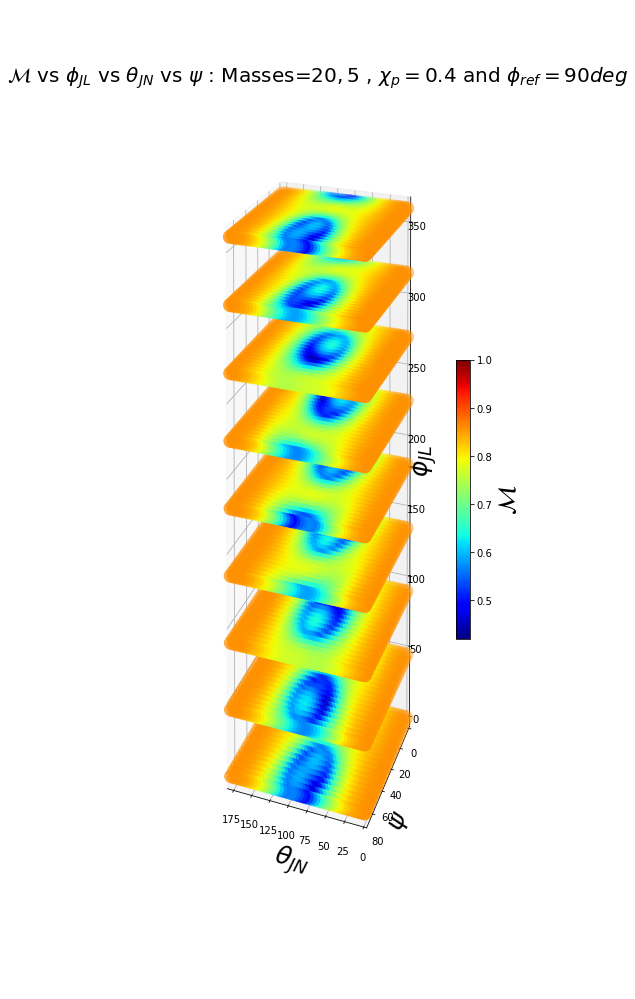

In [10]:
'''3D Plot: phiJL vs thetaJN vs psi vs Match'''
fig1=py.figure(figsize=figsize)
bit = 0.001   
ax = py.axes(projection="3d")
plot1 = ax.scatter(thetaJN_plot3D,psi_plot3D,phiJL_plot3D,c=match2_3D.flatten(),vmax=1.,vmin=0.42,s=dotsize,cmap='jet',edgecolor="none")
#plot1 = ax.scatter(thetaJN_plot3D,psi_plot3D,match2_3D,c=phiJL_plot3D.flatten(),s=100,cmap='hsv',edgecolor="none")
ax.set_xlabel("$\\theta_{JN}$", fontsize = 25)
ax.set_ylabel("$\psi$", fontsize = 25)
ax.set_zlabel("$\phi_{JL}$", fontsize = 25)
#ax.set_zlabel("$\mathcal{M}$", fontsize = 25)
ax.set_xlim(thetaJN_min-bit,thetaJN_max+bit)
ax.set_ylim(psi_min-bit,psi_max+bit)
ax.set_zlim(JLmin-bit,JLmax+bit)
#ax.set_zlim(0.4,1)
colbar = fig1.colorbar(plot1,fraction=0.05, pad=0.04)
colbar.set_label("$\mathcal{M}$", fontsize=25)
#colbar.set_label("$\phi_{JL}$", fontsize=25)
ax.view_init(elev=8, azim=110)
py.title(title1,fontsize=20)

#py.savefig(name)

print "Masses: ", mass1, ", ", mass2
print "chi_p: ", chi_p
print "phiRef: ", degrees(phase)
print "Lowest match: ", match2_3D.min()

Try this with different values of $\phi_{ref}$. When $\phi_{ref}=0$, you only see the $\mathcal{M}$ pattern move up and down on the $\psi$ axis with varying $\phi_{JL}$. But for $phase>0$, there's a translation on the $\theta_{JN}$ axis too. 

Also, see the bottom plane ($\phi_{JL}=0$) for different $\phi_{ref}$. The spot changes position on both $\psi$ and $\theta_{JN}$ axes.

This implies:
- $\phi_{ref}$ is degenerate with both $\theta_{JN}$ and $\psi$, 
- $\phi_{JL}$ is only degenerate with $\psi$

This makes sense if you consider $\phi_{JL}$ as a contributor to $\phi_{ref}$:
- $\phi_{JL}$ defines the azimuthal angle at which $\bf L$ begins on its precession cone. It's independent of the observer's position except for the definition of the origin - at which point on the cone does the azimuthal angle get measured from? That's dependent on the observer's azimuthal position to the source (i.e. $\phi_{ref}$), and independent from the inclination (and, thusly, $\theta_{JN}$).
- $\phi_{ref}$ then must be degenerate with $\phi_{JL}$ - which we see. But changing the $\phi_{ref}$ a waveform begins also changes the point where $\phi_{JL}$ is measured, thusly changing the precession cone's direction relative to the observer. This leads to a change in the orbital plane's orientation relative to the observer, hence we see the translation in the centre of the spot.

# Opening Angle

Here, we do Plot 2 again, but adding the arc described by the precession cone (assuming $\mathbf{\dot{J}}=0$). We centre it upon the spot. The range of amplitude and phase modulation in a precessing waveform would be, in theory, maximum when the precession cone causes the observer to see the orbital plane sweeping through his line-of-sight.

First thing to do, to understand what's going on:
- set $\chi_p$ pretty high. At least 0.6.
- $\phi_{JL}=90$ to initially set the precession phase orthogonal to the observer.
- $\phi_{ref}=0$ to omit any adjustments to the inital orbital phase.

Now the spot will be central on the $\psi$ range and $\theta_{JN}$ range. In this case:
- $\theta_{JN}=90$ sits the observer in the initial orbital plane.
- When $\theta_{JN}=90$,  $\psi \sim 45$ gives the lowest matches, as expected since the $\times$-polarised wave undergoes steeper oscillations around the orbital plane.

## Define the opening angle (Lundgren and O'Shaughanessy) :

In [5]:
'''Lundgren Opening Angle'''
def LUNDbeta(m1,m2,spin_x1,spin_z1,freq):
    m1 = m1*MSUN_SI
    m2 = m2*MSUN_SI
    M = m1 + m2
    v = (M*py.pi*freq*G_SI/C_SI**3)**(1./3.)
    
    chi2 = spin_x1**2 + spin_z1**2
    chi = py.sqrt(chi2)
    gamma = m1*chi/m2 * v
    
    Shat  = (spin_x1,0.,spin_z1)
    Lhat  = (0.,0.,1.)
    kappa = dot(Lhat,Shat)

    cosbeta = (1. + kappa*gamma) / sqrt(1. + kappa*gamma + gamma**2)
    beta = arccos(cosbeta)
    return beta

## Define the opening angle (according to LAL):

In [6]:
'''LAL Opening Angle'''
'''PhenomP opening angle'''

def LALbeta(m1,m2,chi_p,spinz1,spinz2,freq):   #Sp = dimensionful perp. spin, SL = dimensionful aligned spin.
    M = m1 + m2
    M_si = M * MSUN_SI
    
    Sp = m1*m1*chi_p/M**2
    SL = (m1*m1*spinz1 + spinz2*m2*m2)/M**2
        
    v = (M_si*pi*freq*G_SI/C_SI**3.)**(1./3.)
    #    v = pow((M*pi*freq*), 1./3.)
    x = v*v
    x2 = x*x
    
    eta = m1*m2 / (m1+m2)**2.
    eta2 = eta*eta
    
    #L0PN = eta/v
    L2PN = (eta*(1.0 + (1.5 + eta/6.0)*x + (3.375 - (19.0*eta)/8. - eta2/24.0)*x2)) / v

    s = Sp / (L2PN + SL)
    s2 = s*s
    cos_beta_lal = pow(sqrt(1.0 + s2), -1)
    cos_beta_half = sqrt( (1.0 + cos_beta_lal) / 2.0 )
    beta_half = arccos(cos_beta_half)
    beta = arccos(cos_beta_lal)
    return beta, beta_half, s2

### *USER INPUT WINDOW* : Same as plot one. Opening angle is calculated internally.

In [23]:
'''Give the source masses (in solar masses)'''
mass1 = 40.
mass2 = 10.

if mass2>mass1:     #Obey the law.
    tmpmass = mass2
    mass2 = mass1
    mass1 = tmpmass

'''Aligned dimensionless spin for each mass'''
'''(-1 to 1)'''
spin_z1 =  0.            #Spin components aligned with L.
spin_z2 =  0.

'''Precessional spin magnitude for each mass'''
'''(0 to 1)'''
chi_perp1   = 0.6      #DON'T EXCEED MAXIMUM SPIN OR BAD THINGS WILL HAPPEN TO YOU.
chi_perp2   = 0.0     #This one is only interesting if the masses are near identical and you're really bored.

'''Give ranges of psi and thetaJN (degrees)'''
psirange = 21      #Number of different psi values to be matched.
psi_min  =  0     #degrees
psi_max  = 90    #degrees

JNrange     =  41    #Number of different thetaJN values to be matched.
thetaJN_min =   0   #degrees
thetaJN_max = 180  #degrees

#------------------------------------------------------------------------------------------------------
#For investigations with spin contributions from both masses:
#chirange = 25
#chiperp1_min = 0
#chiperp1_max = 0.99 
#chiperp2_min = 0
#chiperp2_max = 0.99
#------------------------------------------------------------------------------------------------------

'''Give orientation angles (degrees)'''
phi12     =   0.     #phi12 = azimuthal angle between spins.
    #Remember the circle is only central when phiJL is 90, or 270. 
phi_JL    =  90.    #phi_JL = phase of precession of L around J.
phase     =   0.   #Reference phase = PhiRef in SimInspiralTransformPrecessingNewInitialConditions()

'''Give sky location (zero = above detector)'''
latitude  = 0
longitude = 0

'''Give distance to source in Mpc'''
dist = 410.

'''Give sample rate and frequency limits'''
f_ref   = 30. #Frequency at which paramters are set (highest signal power around 30Hz for zero aligned spin.)
low_f   = 30.      #Starting frequency
#high_f  = 2048.    #Cut-off frequency
delta_t = 1./2048    #Sample rate
#------------------------------------------------------------------------------------------------------
#For fd waveforms
#delta_f = 2048

### Calculate the parameters as before:

In [24]:
''' [No user input required] '''
''' ------------------------ '''

'''Convert angles to radians'''
psi_min     = radians( psi_min )
psi_max     = radians( psi_max )
thetaJN_min = radians( thetaJN_min )
thetaJN_max = radians( thetaJN_max )
phi12     = radians( phi12 )
phi_JL    = radians( phi_JL )
phase = radians( phase )

'''Create array of polarisations and thetaJNs'''
psi      = linspace(psi_min, psi_max, psirange)
theta_JN = linspace(thetaJN_min, thetaJN_max, JNrange)

'''Define spin magnitudes and inclinations'''
chi1     = sqrt(spin_z1**2 + chi_perp1**2)   #Calculate spin magnitude for each mass.
chi2     = sqrt(spin_z2**2 + chi_perp2**2)
if chi1>1:
    chi1=1.0                        #Prevent Kerr limit being exceeded
    print "WARNING: KERR LIMIT EXCEEDED. BLACK HOLE GIVEN EXTREME KERR SPIN INSTEAD. BE BETTER AT MATHS."
if chi2>1:
    chi2=1.0
    print "WARNING: KERR LIMIT EXCEEDED. BLACK HOLE GIVEN EXTREME KERR SPIN INSTEAD. BE BETTER AT MATHS."

if chi1 == 0.: chi1 = 10e-10               #Prevent division by zero.
if chi2 == 0.: chi2 = 10e-10
if spin_z1<0: theta1z = pi               #Gives non-precessing waveform appropriate spin polar angles.
else: theta1z = 0
if spin_z2<0: theta2z = pi
else: theta2z = 0
theta1  = arccos(spin_z1/chi1)       #Calculate polar angle for each mass.
theta2  = arccos(spin_z2/chi2)

'''Calculate chi_eff and chi_p'''
A1 = 1 + 3*mass2/(4*mass1)
A2 = 1 + 3*mass1/(4*mass2)
chi_eff = ( mass1*spin_z1 + mass2*spin_z2 )/(mass1+mass2)

#See Schmidt, Ohme & Hannam (2014): "Towards models of gravitational waves..."
q = mass1/mass2
A1 = 2. + 3.*q/2
A2 = 2. + 3./(2*q)
S1 = chi_perp1*mass1**2
S2 = chi_perp2*mass2**2
top = max(A2*S1,A1*S2)
chi_p = top/(A2*mass1**2)

'''Calculate opening angle'''#                <--------------- Calculate opening angle
beta = LUNDbeta(mass1,mass2,chi_perp1,spin_z1,f_ref)
lalbeta, halfbeta, s2 = LALbeta(mass1,mass2,chi_p,spin_z1,spin_z2,f_ref)

'''Initialise spin, inclination and Match arrays'''
s1x = zeros((psirange,JNrange))
s1y = zeros((psirange,JNrange))
s1z = zeros((psirange,JNrange))
s2x = zeros((psirange,JNrange))
s2y = zeros((psirange,JNrange))
s2z = zeros((psirange,JNrange))
inc = zeros((psirange,JNrange))

match2 = zeros((psirange,JNrange))

'''Set plotting arrays'''
psirangej = complex(0,psirange)
JNrangej  = complex(0,JNrange)
psi_plot,thetajn_plot = mgrid[0:psi_max:psirangej,0:thetaJN_max:JNrangej]

### Create the non-precessing template:

In [25]:
'''CREATE TEMPLATE'''

delta_t = 1./2048

np_inc, np_s1x, np_s1y, np_s1z, np_s2x, np_s2y, np_s2z = SimInspiralTransformPrecessingNewInitialConditions(
                                                               0., #theta_JN
                                                               phi_JL, #phi_JL
                                                               theta1z, #theta1
                                                               theta2z, #theta2
                                                               phi12, #phi12
                                                               abs(spin_z1), #chi1
                                                               abs(spin_z2), #chi2
                                                               mass1*MSUN_SI,
                                                               mass2*MSUN_SI,
                                                               low_f,
                                                               phase)
temp_hplus, temp_hcross = get_td_waveform(approximant="IMRPhenomPv2",
                        inclination = np_inc,
                        mass1=mass1,
                        mass2=mass2,
                        spin1x = np_s1x,
                        spin1y = np_s1y,
                        spin1z = np_s1z,
                        spin2x = np_s2x,
                        spin2y = np_s2y,
                        spin2z = np_s2z,
                        distance = dist,
                        f_lower=low_f,
                        f_ref=f_ref,
                        delta_t=delta_t)

'''Set psi=0 for this one - it doesnt make a difference anyway'''
temp_vec = my_generate_detector_strain(temp_hplus,temp_hcross, 0, latitude, longitude)
delta_f = 1./ len(temp_vec) / delta_t

### Let rip:

In [26]:
'''CREATE SIGNALS AND MATCH TO TEMPLATE'''
for i in range(psirange):  
    for j in range(JNrange):
        inc[i][j],s1x[i][j],s1y[i][j],s1z[i][j],s2x[i][j],s2y[i][j],s2z[i][j], = SimInspiralTransformPrecessingNewInitialConditions(
                                                               theta_JN[j],
                                                               phi_JL,
                                                               theta1,
                                                               theta2,
                                                               phi12,
                                                               chi1,
                                                               chi2,
                                                               mass1*MSUN_SI,
                                                               mass2*MSUN_SI,
                                                               low_f,
                                                               phase)
        splus, scross = get_td_waveform(approximant="IMRPhenomPv2",
                        inclination = inc[i][j],
                        mass1=mass1,
                        mass2=mass2,
                        spin1x = s1x[i][j],
                        spin1y = s1y[i][j],
                        spin1z = s1z[i][j],
                        spin2x = s2x[i][j],
                        spin2y = s2y[i][j],
                        spin2z = s2z[i][j],
                        distance = dist,
                        f_lower=low_f,
                        f_ref=f_ref,
                        delta_t=delta_t)
        
        sig_vec = my_generate_detector_strain(splus,scross, psi[i],latitude,longitude)
        sig_vec.resize(len(temp_vec))
        PSD = aLIGOZeroDetHighPower(len(temp_vec),delta_f,low_f)
        
        match2[i][j], residuals = match(temp_vec,sig_vec,psd=PSD,low_frequency_cutoff=low_f)

### Set up lines to plot the precession cone tangent:

In [27]:
'''LUNDGREN BETA'''
x1=linspace(pi/2-beta, pi/2+beta, 10000)
B=x1-pi/2
C = sqrt(beta**2 - B**2)
yplus1 = C + pi/4
yminus1 = -C + pi/4
yplus1 = degrees(C + pi/4)
yminus1 = degrees(-C + pi/4)
x1 = degrees(x1)

/Users/awmuir/src/pycbc/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


In [28]:
'''LAL BETA'''
LALx = linspace(pi/2-lalbeta,pi/2+lalbeta, 10000)        #(x-a)^2 + (y-b)^2 = beta^2
#x2 = linspace(pi/2-halfbeta, pi/2+halfbeta, 100)
sqdiff = lalbeta**2 - (LALx-pi/2)**2
sqdiff[sqdiff<0] = 0
C = sqrt(sqdiff)

LALy1 = pi/4 - C
LALy2 = pi/4 + C

LALy1 = degrees(LALy1)
LALy2 = degrees(LALy2)
LALy1[LALy1<0.] = LALy1[LALy1<0.] + 90.
LALy2[LALy2>90.] = LALy2[LALy2>90.] - 90.

LALx = degrees(LALx)

### *USER INPUT WINDOW*: PLOTTING

In [29]:
'''Give plot save filename (saves with the chosen fixed parameters in the title without user interference)'''
nom0 = str(int(mass1)) + "and" + str(int(mass2))
nom1 = str(chi_p)
nom2 = str(int(round(degrees(phi_JL))))
nom4 = str(int(degrees(phase)))
nom5 = str(int(low_f))
nom6 = str(chi_eff*100) #to avoid including decimal point in filename
if chi_eff==0: nom6 = "0"
name = "BetaCOB" + "_M" + nom0 + "_Chip" + nom1[2:3] + "_chieff" + nom6[0:2] + "_lowf" + nom5
    #+ "_phiJL" + nom2   + "_phase" + nom4 if you're messing with low_f or phase you may want to add them to title.    

'''Choose contour lines'''
lines = [0.6,0.7,0.8,0.9,0.97]

'''Choose figure size (scalar) and dot size'''
figsize=[30,12]
dotsize=1600
linewidth=8

Masses:  40.0 ,  10.0
$\chi_p$:  0.6
$\chi_{eff}$:  0.0
low_f:  30.0
LALbeta ($eta_{LAL}$):  30.896663343749704
Lundgren beta:  34.39582248997914


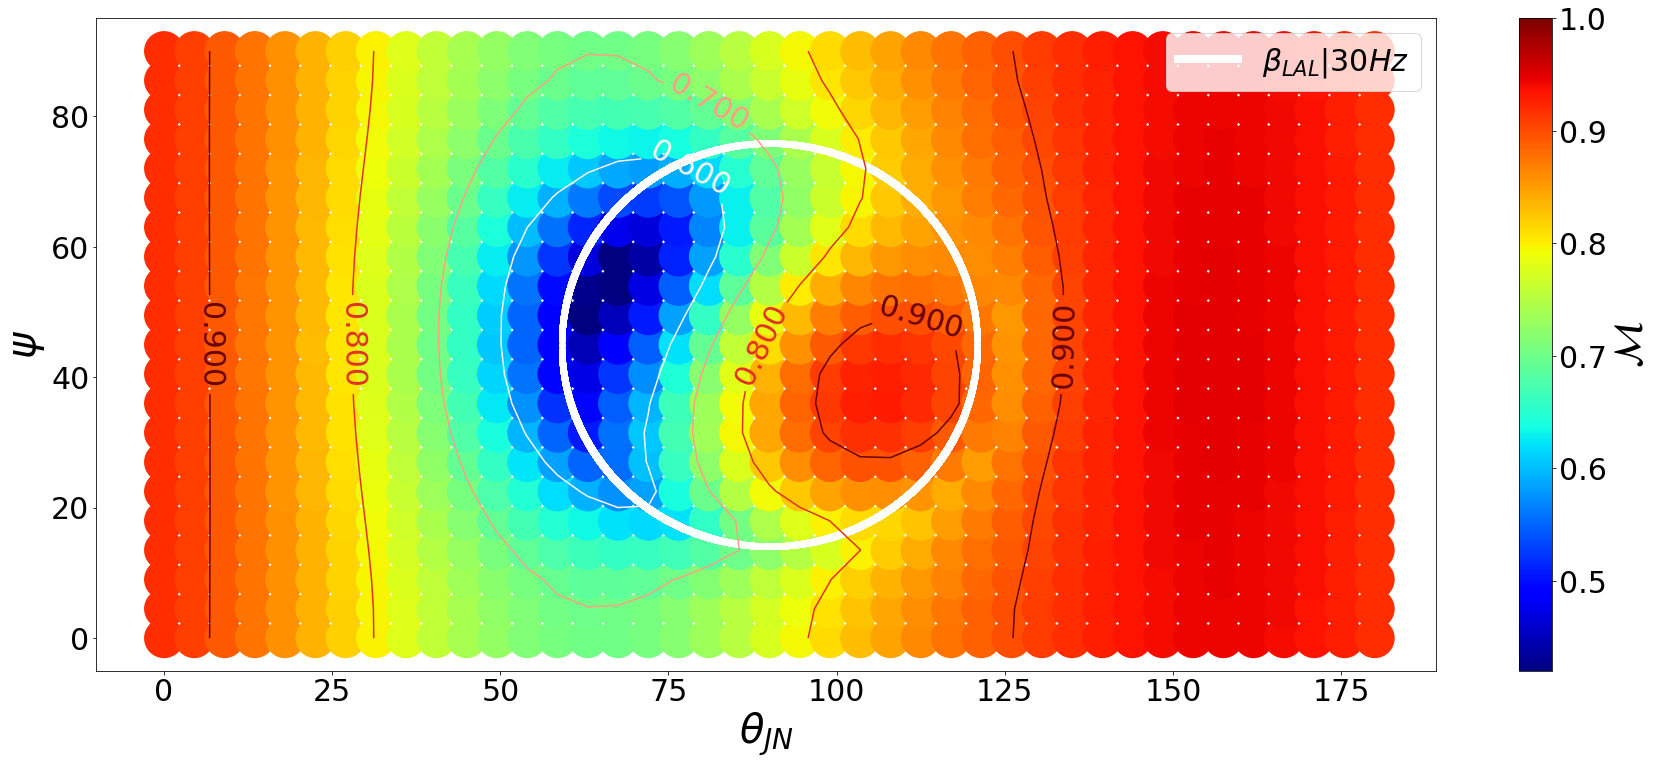

In [30]:
'''Print parameters'''
print "Masses: ", mass1, ", ", mass2
print "$\chi_p$: ", chi_p
print "$\chi_{eff}$: ", chi_eff
print "low_f: ", low_f
print "LALbeta ($\beta_{LAL}$): ", degrees(lalbeta)
print "Lundgren beta: ", degrees(beta)
#print "Minimum match: ", match2.min()

'''Plot Match vs thetaJN vs chi_p'''
fig2 = py.figure(figsize=figsize)
#py.title(title1,fontsize=20)
py.xlabel("$\\theta_{JN}$",fontsize=40)
py.ylabel("$\psi$",fontsize=40)
py.scatter(degrees(thetajn_plot),degrees(psi_plot), c=match2, vmin=.42, vmax=1., s=dotsize, cmap = 'jet', edgecolor='none')
py.tick_params(axis='both', which='both', labelsize=30)
cbar = py.colorbar()
cbar.set_label(label="$\mathcal{M}$",size=40)
cbar.ax.tick_params(labelsize=30)

'''Plot contour lines'''
Cont = py.plt.contour(degrees(thetajn_plot), degrees(psi_plot), match2, lines, cmap = 'Reds')
py.grid(which='both')
py.plt.clabel(Cont, inline=1, fontsize=30)

'''Plot opening angles'''
'''Lundgren'''
#py.plot(x1,yplus1,c='k',linewidth=linewidth)
#py.plot(x1,yminus1,c='k',linewidth=linewidth)
#py.plot(0,0,            'k',linewidth=linewidth,label="$\\beta_{Lund}$")
'''LAL'''
py.plot([-1,-1],[-1,-1],'w',linewidth=linewidth,label="$\\beta_{LAL}|30Hz$")
py.scatter(LALx[:],LALy1[:],c="white")
py.scatter(LALx[:],LALy2[:],c="white")

py.ylim(-5,95)

py.grid(axis='both',which='both')
py.legend(loc="upper right", prop={'size': 30})
py.savefig(name)
py.show()


## Match Differentials

Here I use the colour axes to show the difference in Match between two sets where the parameters are different. This requires running the Plot 2 code twice and storing both results (i.e. storing the first run's results in a new array before running the code again with different parameters).

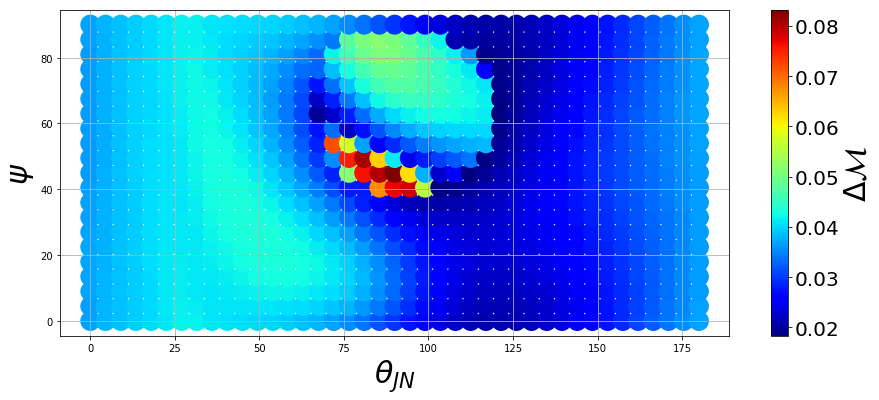

In [142]:
'''Match differentials between runs for chi_p=0.7, eta=4 and chi_p=0.4, eta=7, all other parameters constant'''

'''Plot Match vs thetaJN vs chi_p'''
fig2 = py.figure(figsize=figsize)
#py.title(title1,fontsize=20)
py.xlabel("$\\theta_{JN}$",fontsize=30)
py.ylabel("$\psi$",fontsize=30)
py.scatter(degrees(thetajn_plot), degrees(psi_plot), c=matchdiff, s=dotsize, cmap = 'jet', edgecolor='none')
py.grid(which='both')
cbar = py.colorbar()
cbar.set_label(label="$\Delta\mathcal{M}$",size=30)
cbar.ax.tick_params(labelsize=20)

'''Plot opening angles'''
#py.scatter(LALx,LALy1,c='w',s=8)
#py.scatter(LALx,LALy2,c='w',s=8)
#py.plot(0,0,            'w',linewidth=4,label="$\\beta_{LAL}$")
#py.plot(LALx,LALy1,'m',linewidth=4,label="$\\beta_{LAL}$")
#py.plot(LALx,LALy2,'m',linewidth=4)
#py.ylim(-5,95)
#py.tick_params(axis='both', which='both', labelsize=20)
#py.grid(axis='both')
#py.legend(loc="upper right", prop={'size': 17})

py.savefig("M-differentials_c4e7-c7e4")


For the parameter values set in the description at the top of this section, neither $\beta$ perfectly traces the ring of worst $\mathcal{M}$ (the circle of badness).

In fact, the opening angle does a pretty good job of encompassing the worst $Match$ values. That is to say, nearly all the most precessiony signals lie within the radius of the precession cone.

Increasing the mass ratio makes the ring of badness more lop-sided. Perhaps because one orbit of the precession cone takes more of the waveform to complete, and so the initial conditions which dictate the orientation of the precession cone influence the amount of observed precession much more.

## Plotting $\beta$ vs $\chi_{eff}$

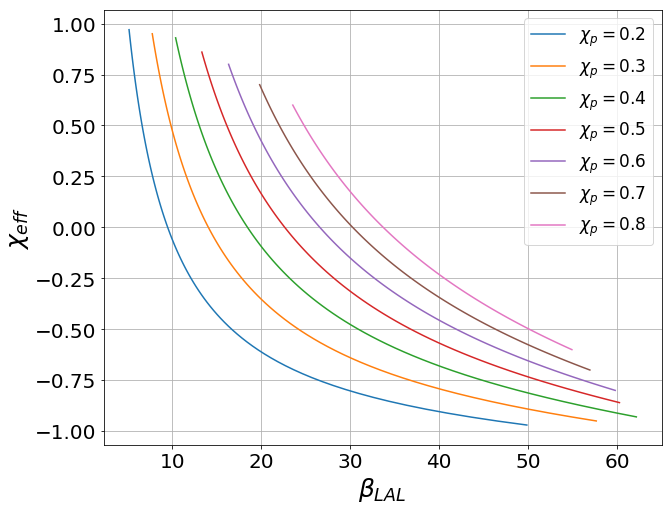

In [523]:
m1 = 20.
m2 = 5.
chip = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]
freq = 30.

z1_2 = linspace(-.97,0.97,101)
z2_2 = z1_2
beta_chip2 = degrees(LALbeta(m1,m2,chip[0],z1_2,z2_2,freq))
z1_3 = linspace(-0.95,0.95,100)
z2_3 = z1_3
beta_chip3 = degrees(LALbeta(m1,m2,chip[1],z1_3,z2_3,freq))
z1_4 = linspace(-0.93,0.93,100)
z2_4 = z1_4
beta_chip4 = degrees(LALbeta(m1,m2,chip[2],z1_4,z2_4,freq))
z1_5 = linspace(-.86,0.86,100)
z2_5 = z1_5
beta_chip5 = degrees(LALbeta(m1,m2,chip[3],z1_5,z2_5,freq))
z1_6 = linspace(-0.8,0.8,100)
z2_6 = z1_6
beta_chip6 = degrees(LALbeta(m1,m2,chip[4],z1_6,z2_6,freq))
z1_7 = linspace(-.7,0.7,100)
z2_7 = z1_7
beta_chip7 = degrees(LALbeta(m1,m2,chip[5],z1_7,z2_7,freq))
z1_8 = linspace(-.6,0.6,100)
z2_8 = z1_8
beta_chip8 = degrees(LALbeta(m1,m2,chip[6],z1_8,z2_8,freq))

py.figure(figsize=[10,8])
py.plot(beta_chip2[0],z1_2,label="$\chi_p=0.2$")
py.plot(beta_chip3[0],z1_3,label="$\chi_p=0.3$")
py.plot(beta_chip4[0],z1_4,label="$\chi_p=0.4$")
py.plot(beta_chip5[0],z1_5,label="$\chi_p=0.5$")
py.plot(beta_chip6[0],z1_6,label="$\chi_p=0.6$")
py.plot(beta_chip7[0],z1_7,label="$\chi_p=0.7$")
py.plot(beta_chip8[0],z1_8,label="$\chi_p=0.8$")
py.xlabel("$\\beta_{LAL}$",fontsize=25)
py.ylabel("$\chi_{eff}$",fontsize=25)
py.legend(loc="upper right", prop={'size': 17})
py.tick_params(axis='both', which='both', labelsize=20)
py.grid(axis='both')
py.savefig("beta-chieff-chip")

## Plotting $\beta$ vs Mass Ratio

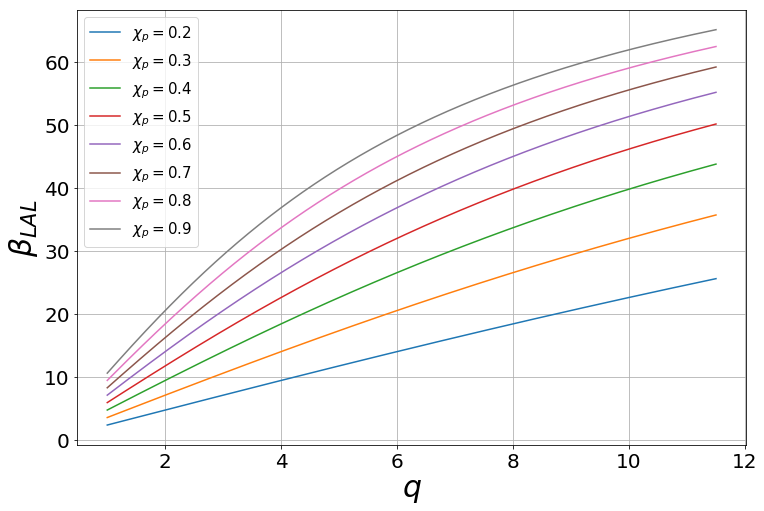

In [4]:
m2 = linspace(2,12.5,1000)
m1 = 25. - m2
eta = m1/m2

chip = [0.2,0.4,0.6,0.8,0.9, 0.3,0.5,0.7]

s1z  =  0.
s2z  =  0.
freq = 30.

betas0= degrees(LALbeta(m1,m2,chip[0],s1z,s1z,freq))
betas1= degrees(LALbeta(m1,m2,chip[1],s1z,s1z,freq))
betas2= degrees(LALbeta(m1,m2,chip[2],s1z,s1z,freq))
betas3= degrees(LALbeta(m1,m2,chip[3],s1z,s1z,freq))
betas4= degrees(LALbeta(m1,m2,chip[4],s1z,s1z,freq))
betas5= degrees(LALbeta(m1,m2,chip[5],s1z,s1z,freq))
betas6= degrees(LALbeta(m1,m2,chip[6],s1z,s1z,freq))
betas7= degrees(LALbeta(m1,m2,chip[7],s1z,s1z,freq))
#betas8= degrees(LALbeta(m1,m2,chip[8],s1z,s1z,freq))

py.figure(figsize=[12,8])
py.plot(eta,betas0[0],label="$\chi_p=0.2$")
py.plot(eta,betas5[0],label="$\chi_p=0.3$")
py.plot(eta,betas1[0],label="$\chi_p=0.4$")
py.plot(eta,betas6[0],label="$\chi_p=0.5$")
py.plot(eta,betas2[0],label="$\chi_p=0.6$")
py.plot(eta,betas7[0],label="$\chi_p=0.7$")
py.plot(eta,betas3[0],label="$\chi_p=0.8$")
py.plot(eta,betas4[0],label="$\chi_p=0.9$")


py.ylabel("$\\beta_{LAL}$",fontsize=30)
py.xlabel("$q$",fontsize=30)
py.legend(loc="upper left", prop={'size': 15})
py.tick_params(axis='both', which='both', labelsize=20)
py.grid(which="both")
py.savefig("Beta-eta-chip")


## Plotting $\beta$ Time-Evolution

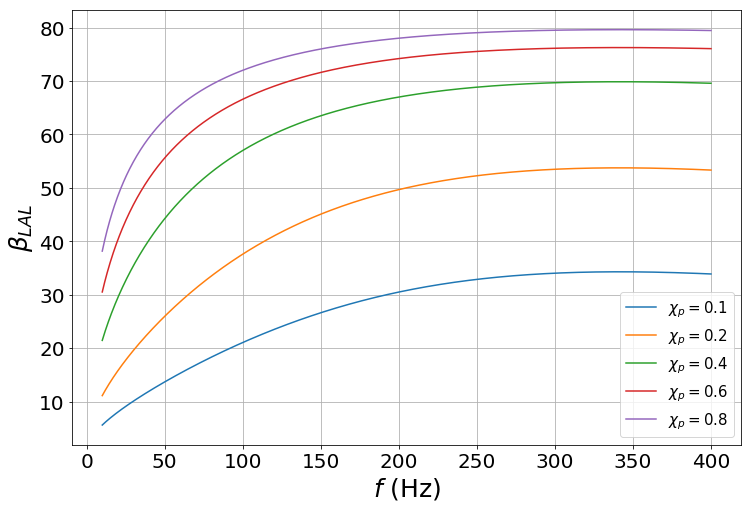

In [65]:
m1 = 20.
m2 =  5.
#chip = 0.6
s1z = -0.6
s2z = -0.6
freq = linspace(10,400,1000)

chip = [0.1,0.2,0.4,0.6,0.8]

betas0= degrees(LALbeta(m1,m2,chip[0],s1z,s1z,freq))
betas2= degrees(LALbeta(m1,m2,chip[1],s1z,s1z,freq))
betas4= degrees(LALbeta(m1,m2,chip[2],s1z,s1z,freq))
betas6= degrees(LALbeta(m1,m2,chip[3],s1z,s1z,freq))
betas8= degrees(LALbeta(m1,m2,chip[4],s1z,s1z,freq))

py.figure(figsize=[12,8])

py.plot(freq,betas0[0],label="$\chi_p=0.1$")
py.plot(freq,betas2[0],label="$\chi_p=0.2$")
py.plot(freq,betas4[0],label="$\chi_p=0.4$")
py.plot(freq,betas6[0],label="$\chi_p=0.6$")
py.plot(freq,betas8[0],label="$\chi_p=0.8$")

#py.plot(-betas0[0],freq,label="$\chi_p=0.1$")
#py.plot(-betas2[0],freq,label="$\chi_p=0.2$")
#py.plot(-betas4[0],freq,label="$\chi_p=0.4$")
#py.plot(-betas6[0],freq,label="$\chi_p=0.6$")
#py.plot(-betas8[0],freq,label="$\chi_p=0.8$")
    
py.ylabel("$\\beta_{LAL}$",fontsize=25)
py.xlabel("$f$ (Hz)",fontsize=25)
py.legend(loc="lower right", prop={'size': 15})
py.tick_params(axis='both', which='both', labelsize=20)
py.grid(axis='both')
py.savefig("Beta-evolution_chip6_chieff-6")

# Conclusions

Any precessing waveform will give a quasi-symmetric circular distribution of bad matches somewhere in the $[\theta_{JN},\psi]$ plane, with better matches radiating outward from the circle's radius.

Combinations of $[m_1,m_2]$ affect the size of the precession cone, and thusly the size of the circle of badness.

Reducing $\chi_p$ predictably reduces the ring's radius and increases $\mathcal{M}$ across the entire plane.

Combinations of $[\phi_{JL}, \phi_{ref}]$ affect the direction of the precession cone, and thusly the position of the circle in the $[\theta_{JN},\psi]$ plane.

The effects of $\chi_{eff}>0$ are simply to symmetrise the circle. I expect this is due to the aligned spin increasing the length of the waveform and so decreasing the significance of the initial conditions.

Precessing waveforms where $\chi_p\cdot\eta=constant$ are very similar for most parameter space (for $\chi_{eff}=0$).

The effects of $\chi_{eff}<0$ are unintelligle to me. Such values increase the inspiral rate (since $\bf |J|$ is smaller), and so increase the effect of initial conditions. For example, a fast inspiral may not complete more than one or two precession cycles, thus the orientation where most of the waveform power occurs will be largely dependent on the orientation at the inital frequency. But I don't know why this would utterly destroy the circle of badness the way it does.

*-------------------------------------------------------------------------------------------------------------*

Now we have a pretty good idea of how each paramter in the set $[m_1,m_2,\chi_p,\chi_{eff},\theta_{JN},\psi,\phi_{JL},\phi_{ref}]$ affects observable precession. The next notebook in this series attempts to find accurate and precise equations between each of these parameters and the observable precession in the waveforms they create (fixing the other parameters at specific values until they are generally incorporated into the equation).

I haven't devoted any investigation to sky location, but if one tinkers with those values they shall see the same effect to some change in the values of $[\phi_{JL},\psi,\phi_{ref}]$. This is due to the fact that sky location is, in effect, the orientation of the detector with respect to the source - which is a translation of the orientation of the source with respect to the detector (defined by the three orientation angles). Understanding how sky location affects observable precession is key, since the detector response must be considered to have any idea what portions of parameter space are worth including in any prospective "precessing template bank". 

A parameter which models observable precession without sky location is effectively a parameter for observable precession from an overhead source. The inclusion of sky location turns it into a totally generic parameter for observable precession.

#### *See "Investigating CBC Observable Precession (2 of 2) - Parametrizing Observable Precession*